In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.preprocessing import LabelEncoder
from torchvision.models import densenet201, DenseNet201_Weights
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from PIL import Image

In [3]:

data_dir = 'Desktop\BrainTumour\Dataset\CT'

data_dir = 'C:/Users/ACER/Desktop/BrainTumour/Dataset/CT'
image_size = (224, 224)
batch_size = 16


def load_images(data_dir, image_size):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = image / 255.0  # Normalize to [0, 1]
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images(data_dir, image_size)


label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)


class BrainCTscanDataset:
    def __init__(self, images, labels):  # Add constructor with parameters
        self.images = images
        self.labels = labels
        
    def __len__(self):  # Note: double underscores, not single
        return len(self.images)
    
    def __getitem__(self, idx):  # Note: double underscores, not single
        return self.images[idx], self.labels[idx]

train_dataset = BrainCTscanDataset(X_train, y_train)
val_dataset = BrainCTscanDataset(X_val, y_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\ACER\AppData\Local\Temp\ipykernel_15400\2533927395.py:1: SyntaxWarning: invalid escape sequence '\B'
  data_dir = 'Desktop\BrainTumour\Dataset\CT'


In [4]:
np.save('labels.npy',label_encoder.classes_)

In [5]:
class SimpleEfficientNet(nn.Module):
    def __init__(self, num_classes, model_name='efficientnet_b0'):
        super(SimpleEfficientNet, self).__init__()
        
        # Load pretrained EfficientNet
        if model_name == 'efficientnet_b0':
            self.model = models.efficientnet_b0(pretrained=True)
        elif model_name == 'efficientnet_b1':
            self.model = models.efficientnet_b1(pretrained=True)
        elif model_name == 'efficientnet_b2':
            self.model = models.efficientnet_b2(pretrained=True)
        else:
            raise ValueError(f"Unsupported model name: {model_name}")
        
        # Replace classifier
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
def setup_model(num_classes, model_name='efficientnet_b0', learning_rate=0.001):
    # Initialize model
    model = SimpleEfficientNet(num_classes, model_name)
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, criterion, optimizer, device

In [7]:
num_classes = len(label_encoder.classes_)
model, criterion, optimizer, device = setup_model(
    num_classes=num_classes,
    model_name='efficientnet_b0',
    learning_rate=0.001
)

C:\Users\ACER\anaconda3\envs\tf_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ACER\anaconda3\envs\tf_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/5


Validation: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s, loss=0.0094, acc=95]   



Training Loss: 0.1373, Training Acc: 94.96%
Validation Loss: 0.1497, Validation Acc: 95.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       467
           1       1.00      0.90      0.95       456

    accuracy                           0.95       923
   macro avg       0.96      0.95      0.95       923
weighted avg       0.95      0.95      0.95       923

Saved new best model with validation accuracy: 95.02%

Epoch 2/5


Validation: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s, loss=0.00653, acc=97.1]



Training Loss: 0.0679, Training Acc: 98.10%
Validation Loss: 0.1039, Validation Acc: 97.07%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       467
           1       1.00      0.94      0.97       456

    accuracy                           0.97       923
   macro avg       0.97      0.97      0.97       923
weighted avg       0.97      0.97      0.97       923

Saved new best model with validation accuracy: 97.07%

Epoch 3/5


Validation: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s, loss=0.00288, acc=98.3]



Training Loss: 0.0517, Training Acc: 98.48%
Validation Loss: 0.0459, Validation Acc: 98.27%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       467
           1       1.00      0.97      0.98       456

    accuracy                           0.98       923
   macro avg       0.98      0.98      0.98       923
weighted avg       0.98      0.98      0.98       923

Saved new best model with validation accuracy: 98.27%

Epoch 4/5


Validation: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s, loss=0.00141, acc=99.2] 



Training Loss: 0.0263, Training Acc: 99.05%
Validation Loss: 0.0225, Validation Acc: 99.24%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       467
           1       1.00      0.99      0.99       456

    accuracy                           0.99       923
   macro avg       0.99      0.99      0.99       923
weighted avg       0.99      0.99      0.99       923

Saved new best model with validation accuracy: 99.24%

Epoch 5/5


Validation: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s, loss=0.00482, acc=97.3]



Training Loss: 0.0285, Training Acc: 99.08%
Validation Loss: 0.0767, Validation Acc: 97.29%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       467
           1       1.00      0.95      0.97       456

    accuracy                           0.97       923
   macro avg       0.97      0.97      0.97       923
weighted avg       0.97      0.97      0.97       923



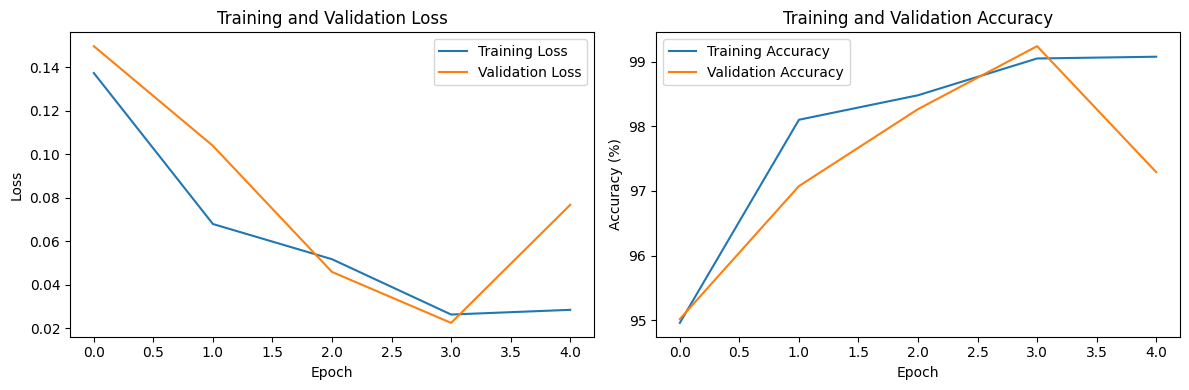

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_efficientnet(model, train_loader, val_loader, criterion, optimizer, 
                      num_epochs, device, scheduler=None):
    # Lists to track metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0
    
    # Training loop
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc='Training')
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': running_loss/total,
                'acc': 100.*correct/total
            })
        
        # Calculate training metrics
        train_loss = running_loss/len(train_loader)
        train_acc = 100.*correct/total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc='Validation')
        
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Store predictions and labels for metrics
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Update progress bar
                val_pbar.set_postfix({
                    'loss': val_loss/total,
                    'acc': 100.*correct/total
                })
        
        # Calculate validation metrics
        val_loss = val_loss/len(val_loader)
        val_acc = 100.*correct/total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Print epoch results
        print(f'\nTraining Loss: {train_loss:.4f}, Training Acc: {train_acc:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%')
        
        # Print detailed classification metrics
        print('\nClassification Report:')
        print(classification_report(all_labels, all_predictions))
        
        # Learning rate scheduling
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss
            }, 'best_model.pth')
            print(f'Saved new best model with validation accuracy: {val_acc:.2f}%')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

def plot_training_results(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Training Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracies'], label='Training Accuracy')
    plt.plot(history['val_accuracies'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


# Train the model
history = train_efficientnet(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=5,
    device=device,
    scheduler=scheduler
)

# Plot training results
plot_training_results(history)

In [9]:
def predict_image(image_path):
    # Remove any quotes
    image_path = image_path.strip('"')
    
    # Verify file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
        
    print(f"Image shape before resize: {image.shape}")  # Debug info
    
    image = cv2.resize(image, image_size)
    print(f"Image shape after resize: {image.shape}")  # Debug info
    
    image = image / 255.0
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    print(label_encoder.inverse_transform([predicted.item()])[0])
predict_image('"C:/Users/ACER/Desktop/BrainTumour/Dataset/CT/Tumor/ct_tumor (153).jpg"')

Image shape before resize: (640, 640, 3)
Image shape after resize: (224, 224, 3)
Tumor
